In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 10989416.84it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37549812.10it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 9022759.99it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6235852.30it/s]


Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [01:03,  1.87it/s]                         


Epoch 1 of 100
Generator loss: 0.05875173, Discriminator loss: 0.08376987


118it [01:11,  1.64it/s]                         


Epoch 2 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:08,  1.73it/s]                         


Epoch 3 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:07,  1.74it/s]                         


Epoch 4 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:10,  1.68it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


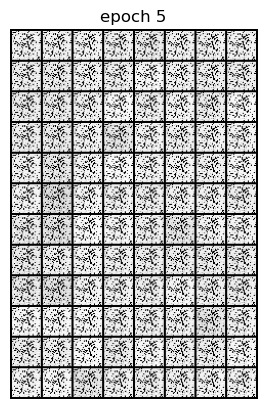

Epoch 5 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:11,  1.65it/s]                         


Epoch 6 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:12,  1.63it/s]                         


Epoch 7 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:13,  1.60it/s]                         


Epoch 8 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:10,  1.66it/s]                         


Epoch 9 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:08,  1.72it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


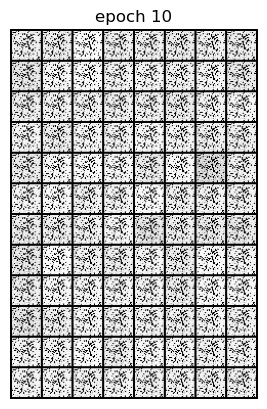

Epoch 10 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:08,  1.73it/s]                         


Epoch 11 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:17,  1.52it/s]                         


Epoch 12 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:10,  1.67it/s]                         


Epoch 13 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:13,  1.60it/s]                         


Epoch 14 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:15,  1.57it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


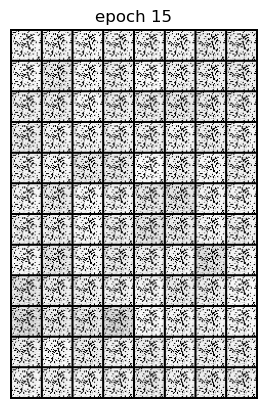

Epoch 15 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:18,  1.50it/s]                         


Epoch 16 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:14,  1.57it/s]                         


Epoch 17 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:18,  1.51it/s]                         


Epoch 18 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:14,  1.58it/s]                         


Epoch 19 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:13,  1.60it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


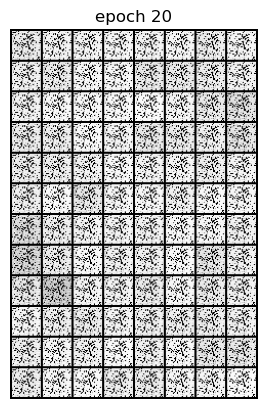

Epoch 20 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:20,  1.47it/s]                         


Epoch 21 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:15,  1.57it/s]                         


Epoch 22 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:13,  1.60it/s]                         


Epoch 23 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:05,  1.79it/s]                         


Epoch 24 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:05,  1.81it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


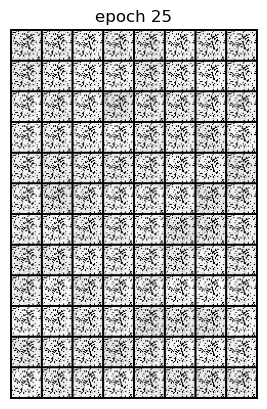

Epoch 25 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:08,  1.72it/s]                         


Epoch 26 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:05,  1.81it/s]                         


Epoch 27 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.84it/s]                         


Epoch 28 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:02,  1.87it/s]                         


Epoch 29 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.86it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


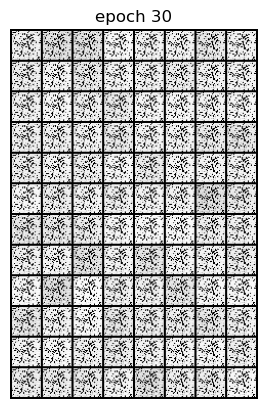

Epoch 30 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.85it/s]                         


Epoch 31 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.83it/s]                         


Epoch 32 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.86it/s]                         


Epoch 33 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.87it/s]                         


Epoch 34 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.83it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


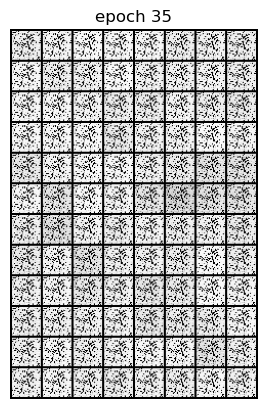

Epoch 35 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:07,  1.76it/s]                         


Epoch 36 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:06,  1.78it/s]                         


Epoch 37 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:06,  1.78it/s]                         


Epoch 38 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.85it/s]                         


Epoch 39 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.85it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


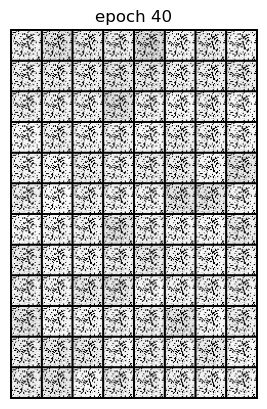

Epoch 40 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:07,  1.75it/s]                         


Epoch 41 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.82it/s]                         


Epoch 42 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:05,  1.81it/s]                         


Epoch 43 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:12,  1.63it/s]                         


Epoch 44 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:08,  1.73it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


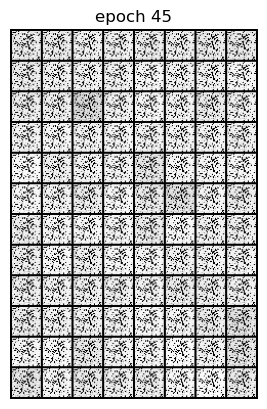

Epoch 45 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:12,  1.62it/s]                         


Epoch 46 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:15,  1.55it/s]                         


Epoch 47 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:09,  1.70it/s]                         


Epoch 48 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:13,  1.61it/s]                         


Epoch 49 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.83it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


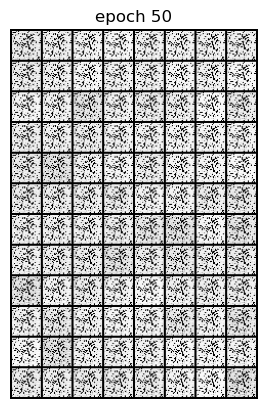

Epoch 50 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.82it/s]                         


Epoch 51 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.84it/s]                         


Epoch 52 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:05,  1.79it/s]                         


Epoch 53 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.82it/s]                         


Epoch 54 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:06,  1.78it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


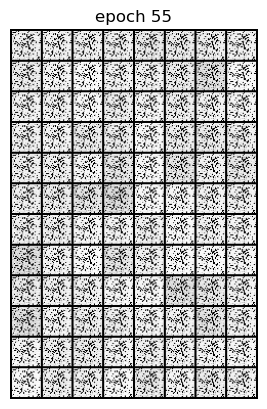

Epoch 55 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.85it/s]                         


Epoch 56 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.87it/s]                         


Epoch 57 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.85it/s]                         


Epoch 58 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:02,  1.88it/s]                         


Epoch 59 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.83it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


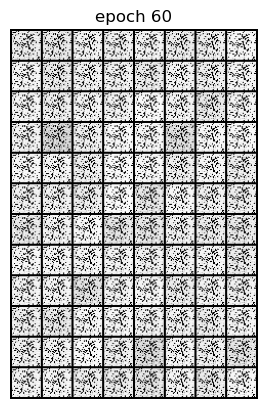

Epoch 60 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:06,  1.77it/s]                         


Epoch 61 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:07,  1.74it/s]                         


Epoch 62 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:10,  1.67it/s]                         


Epoch 63 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.84it/s]                         


Epoch 64 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:02,  1.89it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


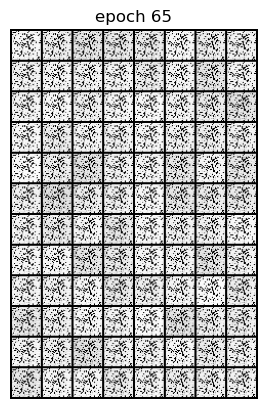

Epoch 65 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:08,  1.73it/s]                         


Epoch 66 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.83it/s]                         


Epoch 67 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:05,  1.79it/s]                         


Epoch 68 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:09,  1.70it/s]                         


Epoch 69 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.82it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


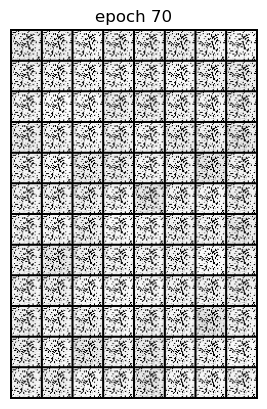

Epoch 70 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:05,  1.80it/s]                         


Epoch 71 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.83it/s]                         


Epoch 72 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:09,  1.71it/s]                         


Epoch 73 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:05,  1.79it/s]                         


Epoch 74 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:02,  1.88it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


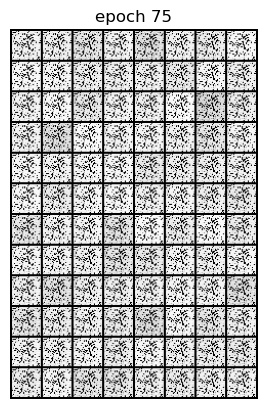

Epoch 75 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.84it/s]                         


Epoch 76 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.83it/s]                         


Epoch 77 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:05,  1.80it/s]                         


Epoch 78 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.86it/s]                         


Epoch 79 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.84it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


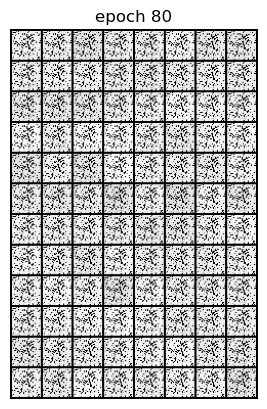

Epoch 80 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:04,  1.84it/s]                         


Epoch 81 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [01:03,  1.86it/s]                         


Epoch 82 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:45,  2.59it/s]                         


Epoch 83 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:38,  3.10it/s]                         


Epoch 84 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:38,  3.09it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


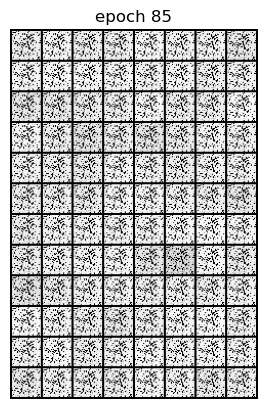

Epoch 85 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:37,  3.13it/s]                         


Epoch 86 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:38,  3.06it/s]                         


Epoch 87 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:38,  3.08it/s]                         


Epoch 88 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:38,  3.09it/s]                         


Epoch 89 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:38,  3.04it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


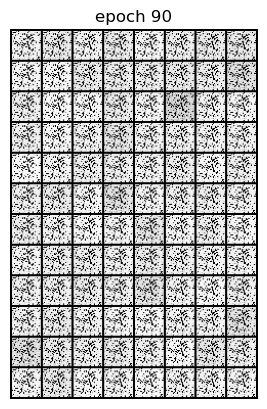

Epoch 90 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:40,  2.92it/s]                         


Epoch 91 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:47,  2.50it/s]                         


Epoch 92 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:39,  3.01it/s]                         


Epoch 93 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:37,  3.16it/s]                         


Epoch 94 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:37,  3.16it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


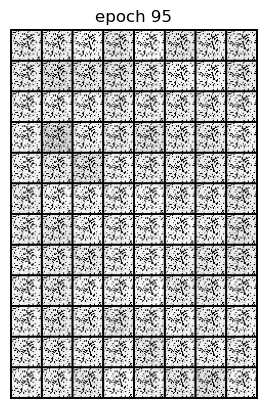

Epoch 95 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:39,  2.96it/s]                         


Epoch 96 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:40,  2.92it/s]                         


Epoch 97 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:39,  2.97it/s]                         


Epoch 98 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:40,  2.92it/s]                         


Epoch 99 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:41,  2.83it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


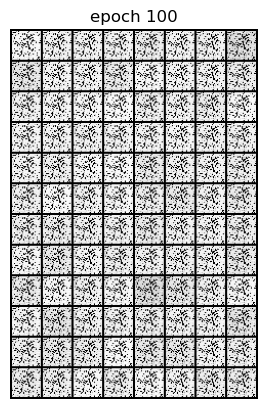

Epoch 100 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


In [14]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    
    return -torch.mean(torch.log(1 - output))
    
    
    ######################################
    
def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    
    return criterion(output, true_label)
    
    
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        image, _ = data
        image = image.to(device)
        
        true_label = label_real(image.size(0))
        true_output = discriminator(image)
        discriminator_loss_real = discriminator_loss(true_output, true_label)

        noise = create_noise(image.size(0), nz)
        fake_image = generator(noise)
        fake_label = label_fake(image.size(0))
        fake_output = discriminator(fake_image)
        discriminator_loss_fake = discriminator_loss(fake_output, fake_label)  
        dis_loss = discriminator_loss_real + discriminator_loss_fake
        optim_d.zero_grad()
        dis_loss.backward()
        optim_d.step()

        
        noise = create_noise(image.size(0), nz)
        fake_image = generator(noise)
        output = discriminator(fake_image)
        true_label = label_real(image.size(0))
        gen_loss = generator_loss(output, true_label)        
        optim_g.zero_grad()
        gen_loss.backward()
        optim_g.step()

        loss_g += gen_loss.item()
        loss_d += dis_loss.item()
    
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

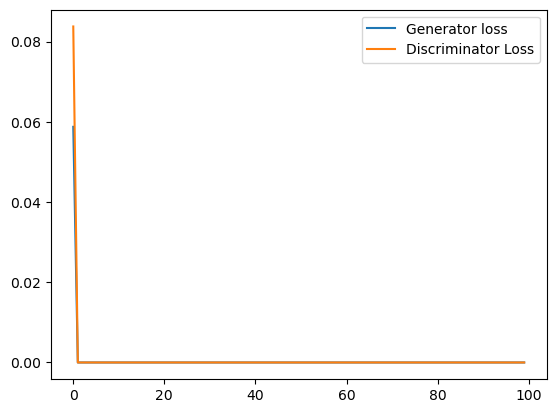

In [17]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')